# Natural Language Processing with Disaster Tweets

<font color='darkblue'> In this project, I will be participating in the NLP with Disaster Tweets Kaggle competition, where the task is to predict whether or not a tweet is about a real disaster. I plan to implement several machine learning techniques to classify this text data and ultimately identify the most effective NLP approach. 

<font color='darkblue'> You can find the dataset here: https://www.kaggle.com/c/nlp-getting-started

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Exploration

<font color='darkblue'>There are 7613 and 3263 data points in the train and test datasets, respectively. In the train dataset, 43.0% of the tweets are of real disasters and the remaining 57.0% are fake.

In [2]:
print("Train Data: {} rows and {} columns".format(train.shape[0], train.shape[1]))
print("Test Data: {} rows and {} columns".format(test.shape[0], test.shape[1]))


target_counts = train.groupby('target')['target'].count()
# Create a DataFrame with counts and percentages
target_summary = pd.DataFrame({
    'count': target_counts,
    'percentage': (target_counts / train['target'].count())*100
})

target_summary

Train Data: 7613 rows and 5 columns
Test Data: 3263 rows and 4 columns


,count,percentage
target,,
0,4342,57.034021
1,3271,42.965979


### Splitting Training Data: 70% for Training Set, 30% for Development Set

<font color='darkblue'> Since we do not know the correct values of labels in the test data, we will split the training data from Kaggle into a training set and a development set (a development set is a held out subset of the labeled data that we set aside in order to fine-tune models, before evaluating the best model(s) on the test data). The idea is that we will train different models on the training set, and compare their performance on the development set, in order to decide what to submit to Kaggle.

In [3]:
from sklearn.model_selection import train_test_split

train_set, dev_set = train_test_split(train, test_size=0.3, random_state=42)

In [4]:
dev_set.shape

(2284, 5)

## Preprocessing Data

### 1) Converting all words to lowercase

<font color='darkblue'> Converting words to lowercase helps with dimensionality reduction. Words like "Heat" and "het" are considered different by most algorithms if case sensitivity is preserved, so lowercasing makes sure that such variations are treated uniformly. This helps models focus on the meaning of words rather than their formatting, improving consistency and accuracy in this classification task.

In [5]:
train_set2 = train_set.copy()
train_set2.text = train_set2.text.str.lower()
train_set2.head()

,id,keyword,location,text,target
1186,1707,bridge%20collapse,NaN,ashes 2015: australiaûªs collapse at trent br...,0
4071,5789,hail,"Carol Stream, Illinois",great michigan technique camp\nb1g thanks to @...,1
5461,7789,police,Houston,cnn: tennessee movie theater shooting suspect ...,1
5787,8257,rioting,NaN,still rioting in a couple of hours left until ...,1
7445,10656,wounds,Lake Highlands,crack in the path where i wiped out this morni...,0


### 2) Eliminating punctuation

<font color='darkblue'>  Much like converting words to lowercase, removing punctuation in NLP helps with dimensionality reduction. Punctuation marks often don't carry significant semantic meaning in many tasks, particularly when the focus is on classification. Hence, eliminating punctuation helps to make the feature space  less noisy, which can improve the model's generalizability. This in-turn allows the model to concentrate on the text’s content rather than on formatting elements that add little to the underlying meaning. 
    
<font color='darkblue'> I chose to eliminate punctuation before lemmatization, because punctuation can interfere with accurately identifying word roots and forms.

In [6]:
train_set2['text'] = train_set2['text'].str.replace(r'[^\x00-\x7F]+|[^\w\s]', '', regex=True)
train_set2['keyword'] = train_set2['keyword'].str.replace(r'[^\x00-\x7F]+|[^\w\s]', '', regex=True)
train_set2.head()

,id,keyword,location,text,target
1186,1707,bridge20collapse,NaN,ashes 2015 australias collapse at trent bridge...,0
4071,5789,hail,"Carol Stream, Illinois",great michigan technique camp\nb1g thanks to b...,1
5461,7789,police,Houston,cnn tennessee movie theater shooting suspect k...,1
5787,8257,rioting,NaN,still rioting in a couple of hours left until ...,1
7445,10656,wounds,Lake Highlands,crack in the path where i wiped out this morni...,0


### 3) Lemmatization

<font color='darkblue'> Lemmatization aids in NLP tasks by grouping morphologically related words together (i.e. reducing words to their root form) and treating them similarly. This normalization process reduces the vocabulary size, helping with dimensionality reduction. Moreover, focusing the model on core meanings rather than variations in word forms improves accuracy, precision, and efficiency of our model.
    
<font color='darkblue'> Another notable preprocessing step in NLP is stemming. The practical distinction between stemming and lemmatization is that, where stemming merely removes common suffixes from the end of word tokens, lemmatization ensures the output word is an existing normalized form of the word (for example, lemma) that can be found in the dictionary. (Link: https://www.ibm.com/topics/stemming-lemmatization)
    
<font color='darkblue'> A note on lemmatization: Part of speech (POS) tagging is a crucial step in lemmatization. POS essentially assigns each word tag signifying its syntactic function in the sentence.

In [7]:
#!pip install nltk
import nltk### Converting all words to lowercaseMuch like converting words to lowercase, eliminating punctuations helps with dimensionality reduction. I believe removing punctuations can help with cleaner and simpler lemmatization. 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

#nltk.download('wordnet');
#nltk.download('omw-1.4');
#nltk.download('averaged_perceptron_tagger');
#nltk.download('punkt');

In [8]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

lemmatizer = WordNetLemmatizer()

# Function to get WordNet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.NOUN


def lemmatize_text(text):
    words = nltk.word_tokenize(text) 
    pos_tags = pos_tag(words)  
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_words)


train_set2['text'] = train_set2['text'].apply(lemmatize_text)
train_set2.head()

,id,keyword,location,text,target
1186,1707,bridge20collapse,NaN,ash 2015 australia collapse at trent bridge am...,0
4071,5789,hail,"Carol Stream, Illinois",great michigan technique camp b1g thanks to bm...,1
5461,7789,police,Houston,cnn tennessee movie theater shoot suspect kill...,1
5787,8257,rioting,NaN,still riot in a couple of hour leave until i h...,1
7445,10656,wounds,Lake Highlands,crack in the path where i wipe out this mornin...,0


### 4) Strip stop words

<font color='darkblue'> In natural language processing (NLP), stop words are filtered out to enhance text analysis and computational efficiency. Eliminating stop words can improve the accuracy and relevance of NLP tasks by drawing attention to the more important words or content words. Examples of stop words are "the", "and", "or" etc.

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download('stopwords')  # Uncomment this line if you haven't downloaded the stopwords
# nltk.download('punkt')       # Uncomment this line if you haven't downloaded the punkt tokenizer

stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    if isinstance(text, str):

        words = word_tokenize(text)
       
        return ' '.join([word for word in words if word.lower() not in stop_words])
    return text  


train_set2['text'] = train_set2['text'].apply(remove_stop_words)
train_set2['keyword'] = train_set2['keyword'].apply(remove_stop_words)


train_set2.head()


,id,keyword,location,text,target
1186,1707,bridge20collapse,NaN,ash 2015 australia collapse trent bridge among...,0
4071,5789,hail,"Carol Stream, Illinois",great michigan technique camp b1g thanks bmurp...,1
5461,7789,police,Houston,cnn tennessee movie theater shoot suspect kill...,1
5787,8257,rioting,NaN,still riot couple hour leave class,1
7445,10656,wounds,Lake Highlands,crack path wipe morning beach run surface woun...,0


### 5) Strip @ and URLs

<font color='darkblue'> Since our text is tweets, I will add another step to remove @ and URLs to reduce dimensionality and improve computational efficiency. 

In [10]:
import re
def remove_urls(text):
    url_pattern = r'http[s]?://\S+|www\.\S+|\bhtt(?:p|ps)?[^\s]+\b'
    return re.sub(url_pattern, '', text).strip()

train_set2['text'] = train_set2['text'].apply(remove_urls)
train_set2['text'] = train_set2['text'].str.replace(r'@', '', regex=True)
train_set2.head()

,id,keyword,location,text,target
1186,1707,bridge20collapse,NaN,ash 2015 australia collapse trent bridge among...,0
4071,5789,hail,"Carol Stream, Illinois",great michigan technique camp b1g thanks bmurp...,1
5461,7789,police,Houston,cnn tennessee movie theater shoot suspect kill...,1
5787,8257,rioting,NaN,still riot couple hour leave class,1
7445,10656,wounds,Lake Highlands,crack path wipe morning beach run surface woun...,0


In [11]:
def preprocessing(df):
    df['text'] = df['text'].str.lower()
    df['text'] = df['text'].str.replace(r'[^\x00-\x7F]+|[^\w\s]', '', regex=True)
    df['keyword'] = df['keyword'].str.replace(r'[^\x00-\x7F]+|[^\w\s]', '', regex=True)

    df['text'] = df['text'].apply(lemmatize_text)

    df['text'] = df['text'].apply(remove_stop_words)
    df['keyword'] = df['keyword'].apply(remove_stop_words)

    df['text'] = df['text'].apply(remove_urls)
    df['text'] = df['text'].str.replace(r'@', '', regex=True)
    return df
    

## Bag of Words Model

<font color='darkblue'> The next task is to extract features to represent each tweet using the binary “bag of words” model. The goal is to build a vocabulary from the words appearing in the dataset and to represent each tweet with a feature vector 𝑥 whose length matches the size of the vocabulary. In this representation, 𝑥_𝑖=1 if the 
𝑖th vocabulary word appears in the tweet, and 𝑥_𝑖=0 otherwise.
    
<font color='darkblue'> To accomplish this, I will use the CountVectorizer() class from Scikit-learn, setting the option binary=True to ensure that the feature vectors are binary. Additionally, I will specify the min_df parameter, which establishes a threshold to include only words that appear in at least 𝑘 different tweets. This parameter is crucial for avoiding run-time and memory issues, as well as for eliminating noisy or unreliable features that could negatively impact learning.
    
<font color='darkblue'> I set min_df = 5 after analyzing the word frequency distribution in my train set. The histogram reveals a long tail, indicating that many words appear infrequently, with the mean frequency being 3.97. Most NLP projects recommend a min_df of 5, which helps focus on more common words while reducing noise by eliminating terms that rarely occur. Since the mean is ~4 and 5 is an appropriate choice, I think 5 is a good candidate for the min_df threshold.

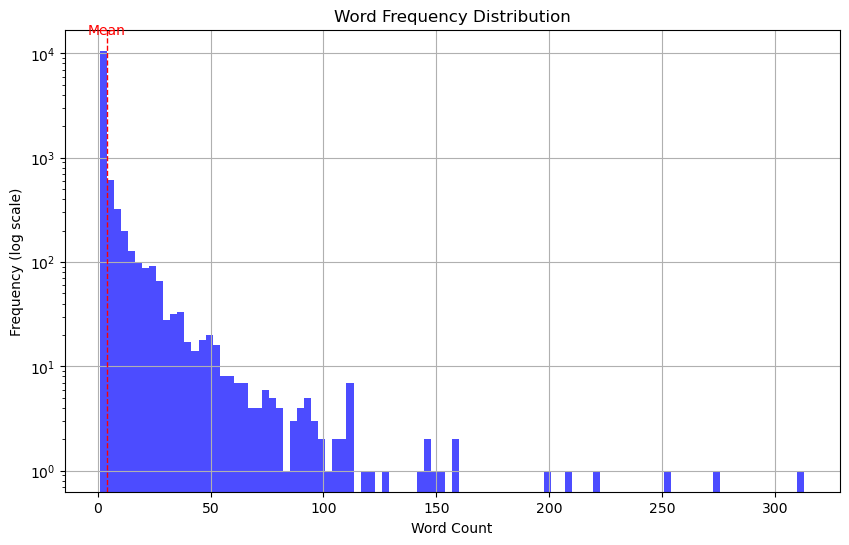

Mean:  3.95
Median:  1.0


In [12]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
word_counts = vectorizer.fit_transform(train_set2['text'])
word_frequencies = np.array(word_counts.sum(axis=0)).flatten()

median = np.percentile(word_frequencies, 50)
mean = np.round(word_frequencies.sum()/len(word_frequencies), 2)

word_freq_df = pd.DataFrame({'Word': vectorizer.get_feature_names_out(),
                             'Frequency': word_frequencies}).sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(10, 6))
plt.hist(word_frequencies, bins=100, log=True, alpha=0.7, color='blue')
plt.title("Word Frequency Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency (log scale)")
plt.grid()

plt.axvline(mean, color='red', linestyle='dashed', linewidth=1)
plt.text(mean, plt.ylim()[1]*0.9, 'Mean', color='red', ha='center')

plt.show()
print("Mean: ", mean)
print("Median: ", median)

<font color='darkblue'> I took a look at the word and frequencies to ensure my preprocessing steps were successful. If there were any stop words or URLs in the dataframe below, I would know there was an error in preprocessing. This would also affect the choice of min_df (M).

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

M = 5  #based on mean and common NLP practices
vectorizer = CountVectorizer(binary=True, min_df=M)

X_train_set = vectorizer.fit_transform(train_set2['text'])
y_train_set = train_set2['target']

dev_set2 = preprocessing(dev_set)
X_dev_set = vectorizer.transform(dev_set2['text'])
y_dev_set = dev_set2['target']

num_features = len(vectorizer.get_feature_names_out())

print(f'Total number of features: {num_features}')

print(f'Training set shape: {X_train_set.shape}')
print(f'Development set shape: {X_dev_set.shape}')
print(f'First 10 words in the vocabulary: {word_freq_df.Word[:10].to_list()}')

Total number of features: 1842
Training set shape: (5329, 1842)
Development set shape: (2284, 1842)
First 10 words in the vocabulary: ['get', 'like', 'fire', 'im', 'amp', 'go', 'via', 'new', 'people', 'news']


## Implementing Logistic Regression (Bag of Words Model)

<font color='darkblue'> Next, I trained a logistic regression models using bag of words feature vectors. I will use the F1/F score as the evaluation metric, the harmonic mean of precision and recall, as it gives a more comprehensive view of classifier performance than accuracy.
    
<font color='darkblue'> I implemented logistic regression without regularization terms (penalty=None). The F1 score for the training set (0.950) is close to 1, indicating that the model performs well in classifying positive instances and maintains a good balance between precision and recall. However, the F1 score for the development set is much lower (0.671) than that of the training set, suggesting that our model is **overfitting** on the training set and not performing as well on unseen data.

In [14]:
f1_scores = {}

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

log_reg = LogisticRegression(penalty=None, solver='saga', max_iter=2000)  # No regularization
log_reg.fit(X_train_set, y_train_set)

y_train_pred = log_reg.predict(X_train_set)
y_dev_pred = log_reg.predict(X_dev_set)

# Calculate F1 scores
f1_train = f1_score(y_train_set, y_train_pred)
f1_dev = f1_score(y_dev_set, y_dev_pred)

# Print F1 Scores
print(f"F1 Score on Training Set using no regularization: {f1_train}")
print(f"F1 Score on Development Set using no regularization: {f1_dev}")

f1_scores['Logistic Regression - No Regularization '] = [f1_train, f1_dev]

F1 Score on Training Set using no regularization: 0.9500769738288981
F1 Score on Development Set using no regularization: 0.6796514607893388


/Users/atmikapai/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<font color='darkblue'> I implemented logistic regression with L1 and L2 regularization. 
    
<font color='darkblue'> 1) The models with regularization are better at generalizability than the one with no regularization, as evidenced by the higher F1 score on the development set (~0.738 L1/L2 regularization vs 0.671 no regularization). Both L1 and L2 models have very similar F1 scores for development set, while L2 has a higher F1 score on the training set. 
    
<font color='darkblue'> 2) The models may still be overfitting, given the substantial difference between the training and development set F1 scores.

In [16]:
log_reg_f1 = LogisticRegression(penalty='l1', solver='saga', max_iter=2000)  # No regularization
log_reg_f1.fit(X_train_set, y_train_set)

y_train_pred = log_reg_f1.predict(X_train_set)
y_dev_pred = log_reg_f1.predict(X_dev_set)

# Calculate F1 scores
f1_train = f1_score(y_train_set, y_train_pred)
f1_dev = f1_score(y_dev_set, y_dev_pred)

# Print F1 Scores
print(f"F1 Score on Training Set using L1 regularization: {f1_train}")
print(f"F1 Score on Development Set using L1 regularization: {f1_dev}")

f1_scores['Logistic Regression - L1 Regularization '] = [f1_train, f1_dev]

log_reg = LogisticRegression(penalty='l2', solver='saga', max_iter=2000)  # No regularization
log_reg.fit(X_train_set, y_train_set)

y_train_pred = log_reg.predict(X_train_set)
y_dev_pred = log_reg.predict(X_dev_set)

# Calculate F1 scores
f1_train = f1_score(y_train_set, y_train_pred)
f1_dev = f1_score(y_dev_set, y_dev_pred)

# Print F1 Scores
print(f"F1 Score on Training Set using L2 regularization: {f1_train}")
print(f"F1 Score on Development Set using L2 regularization: {f1_dev}")

f1_scores['Logistic Regression - L2 Regularization '] = [f1_train, f1_dev]

F1 Score on Training Set using L1 regularization: 0.8339124391938847
F1 Score on Development Set using L1 regularization: 0.7395143487858721
F1 Score on Training Set using L2 regularization: 0.8591160220994476
F1 Score on Development Set using L2 regularization: 0.7387289516567084


In [17]:
f1_scores_df = pd.DataFrame(f1_scores)
f1_scores_df.index = ['Train', 'Development']
f1_scores_df.index.name = 'F1 Scores'
f1_scores_df.T

F1 Scores,Train,Development
Logistic Regression - No Regularization,0.950077,0.679651
Logistic Regression - L1 Regularization,0.833912,0.739514
Logistic Regression - L2 Regularization,0.859116,0.738729


<font color='darkblue'> I examined the weight vector of the classifier with L1 regularization. Below are the 10 most important words for determining whether a tweet is about a real disaster. The sign of each coefficient indicates its correlation with the target variable (e.g. a negative coefficient suggests that the word's presence reduces the likelihood of the tweet being about a real disaster.) The absolute value of the coefficients reflects the strength of each word's influence on the target variable.
    
<font color='darkblue'> Predictably, words like 'hiroshima', 'earthquake', 'typhoon', 'wildfire', references to natural disasters, have high correlation with target variable. 'usagov' and 'mh370' are interesting words,
    

In [18]:
coefficients = log_reg_f1.coef_[0]
feature_names = vectorizer.get_feature_names_out()

importance_df = pd.DataFrame({'word': feature_names, 'coefficient': coefficients})
importance_df['abs_coefficient'] = importance_df['coefficient'].abs()
top_words = importance_df.sort_values(by='abs_coefficient', ascending=False)

top_words.head(10)

,word,coefficient,abs_coefficient
1507,spill,3.472670,3.472670
458,derailment,3.448420,3.448420
780,hiroshima,3.383938,3.383938
1021,mh370,3.273742,3.273742
1027,migrant,3.180301,3.180301
1702,typhoon,3.137763,3.137763
442,debris,3.071324,3.071324
522,earthquake,2.973654,2.973654
1788,wildfire,2.861256,2.861256
1719,usagov,2.758946,2.758946


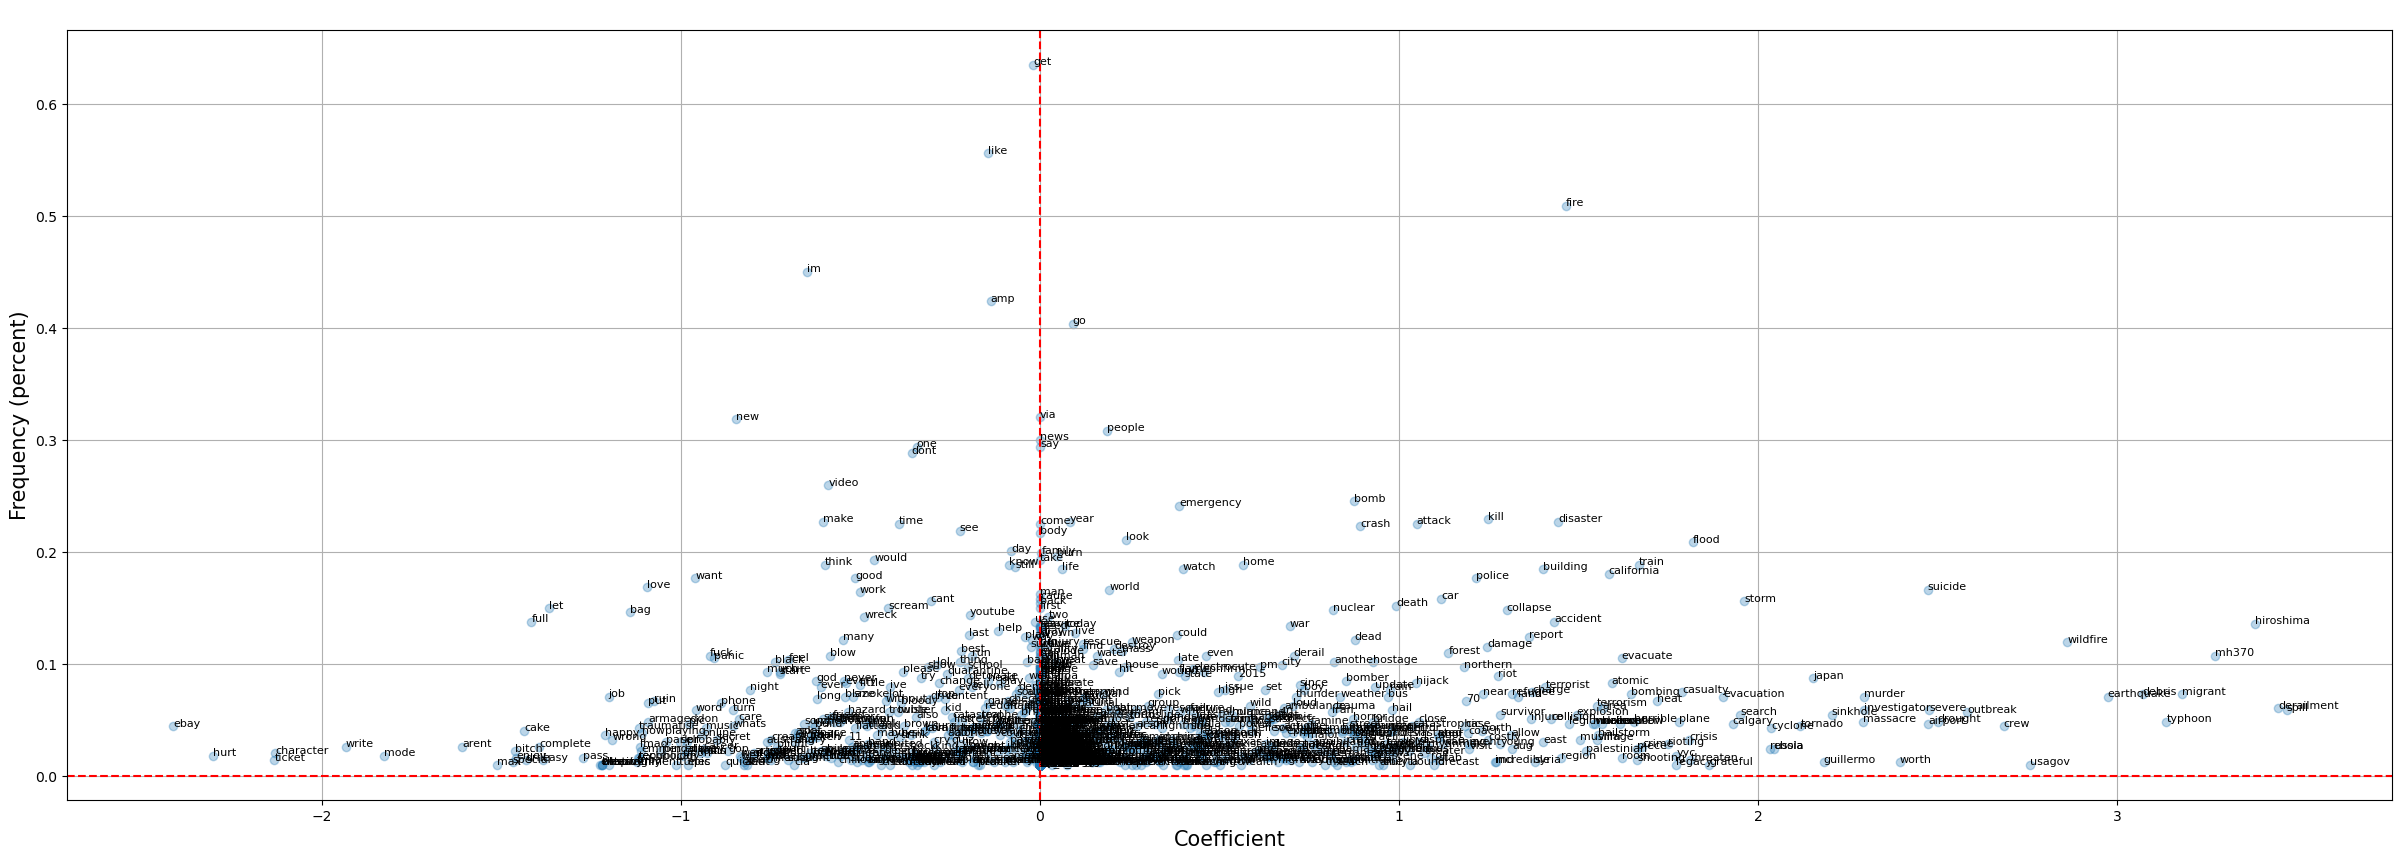

In [19]:
merged1 = pd.merge(top_words, word_freq_df, 
         left_on='word', 
         right_on='Word', 
         how='outer').sort_values(by='coefficient',
                                  ascending=False
                                 )[['word', 'coefficient', 'abs_coefficient', 'Frequency']]

merged1['perc_frequency'] = merged1.Frequency / merged1.Frequency.sum()*100


x = merged1['coefficient'].to_list()
y = merged1['perc_frequency'].to_list()
z = merged1['word'].tolist()


fig = plt.figure(figsize = (30,10))
ax = fig.add_subplot(111)
plt.scatter(x, y, alpha=0.3)
plt.title(' ')
plt.xlabel('Coefficient', size = 15)
plt.ylabel('Frequency (percent)', size = 15)
plt.axhline(0, color='red', linestyle='--')
plt.axvline(0, color='red', linestyle='--')
plt.grid()

for i, txt in enumerate(z):
    ax.annotate(txt, (x[i], y[i]), fontsize=8) 

plt.show()                                                                                                                              

<font color='darkblue'> The majority of data points are clustered around the origin, forming an asymmetrical bell-shaped pattern. The words with coefficients at extreme values have lower frequency and may be less consistent/reliable.

## Implementing Bernoulli Naive Bayes (Bag of Words Model)

<font color='darkblue'> Next, I implemented a Bernoulli Naive Bayes classifier from scratch.

In [20]:
class BernoulliNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_count = len(self.classes)
        self.feature_count = X.shape[1]
        
        self.word_counts = np.zeros((self.class_count, self.feature_count))
        self.class_counts = np.zeros(self.class_count)
        
        for idx, label in enumerate(y):
            self.class_counts[label] += 1
            self.word_counts[label] += X[idx]
        
        #Laplace
        self.probabilities = (self.word_counts + self.alpha) / (self.class_counts[:, None] + 2 * self.alpha)

    def predict(self, X):
        log_prob = np.log(self.probabilities)
        log_prob_complement = np.log(1 - self.probabilities)
        log_prior = np.log(self.class_counts / np.sum(self.class_counts))
        log_likelihood = X @ log_prob.T + (1 - X) @ log_prob_complement.T
        return np.argmax(log_likelihood + log_prior, axis=1)

In [21]:
X_train_binary = X_train_set.toarray()
y_train_binary = y_train_set.tolist()

X_dev_binary = X_dev_set.toarray()
y_dev_binary = y_dev_set.tolist()

nb_classifier = BernoulliNaiveBayes(alpha=1.0)
nb_classifier.fit(X_train_binary, y_train_binary)


y_train_pred = nb_classifier.predict(X_train_binary)
y_dev_pred = nb_classifier.predict(X_dev_binary)

f1_train = f1_score(y_train_binary, y_train_pred)
f1_dev = f1_score(y_dev_binary, y_dev_pred)


# Print F1 Scores
print(f"F1 Score on Training Set using Bernoulli Naive Bayes: {f1_train}")
print(f"F1 Score on Development Set using Bernoulli Naive Bayes: {f1_dev}")

f1_scores['Bernoulli Naive Bayes'] = [f1_train, f1_dev]

F1 Score on Training Set using Bernoulli Naive Bayes: 0.7925873129009264
F1 Score on Development Set using Bernoulli Naive Bayes: 0.7474402730375427


## Generative vs Discriminative Model Comparison

In [22]:
f1_scores_df = pd.DataFrame(f1_scores)
f1_scores_df.index = ['Train', 'Development']
f1_scores_df.index.name = 'F1 Scores'
f1_scores_df.T

F1 Scores,Train,Development
Logistic Regression - No Regularization,0.950077,0.679651
Logistic Regression - L1 Regularization,0.833912,0.739514
Logistic Regression - L2 Regularization,0.859116,0.738729
Bernoulli Naive Bayes,0.792587,0.747440


<font color='darkblue'> With an F1 score of 0.747, Bernoulli Naive Bayes, the generative model, performed the best on the development set.

<font color='darkblue'> **Generative models** (e.g., Naive Bayes) are computationally efficient, particularly with high-dimensional data like text. They are easy to implement/interpret and perform well even on small datasets. 

<font color='darkblue'> However, the model's assumption on feature independence is often violated in text data, where words can be contextually dependent on each other.  

<font color='darkblue'> **Discriminative models** (e.g., logistic regression) typically provide superior performance by effectively modeling complex decision boundaries and interactions between features. 

<font color='darkblue'> However, these models do not capture the underlying data distribution, which can lead to overfitting if not properly regularized.

### Model Assumptions

<font color='darkblue'> **Bernoulli Naive Bayes:** This model assumes that all features are conditionally independent given the class label. This is not necessarily true in NLP taasks, since words can be contextually dependent on each other.
    
<font color='darkblue'> **Logistic Regression:** This model does not assume independence among features, however, it does assumes a linear relationship between the target variable and the log odds of the dependent variable.
    
<font color='darkblue'> Using Bernoulli Naive Bayes for text classification is valid and efficient, particularly with binary or categorical data. However, its independence assumption may hinder performance compared to models like logistic regression, which don't have feature dependency assumptions. Interestingly, in the case above, Bernoulli outperformed logistic regression.

# N-Gram Model

<font color='darkblue'> The N-gram model is similar to the bag of words model, but instead of using individual words we use N-grams, which are contiguous sequences of words. For example, using N = 2, we would says that the text “Alice fell down the rabbit hole” consists of the sequence of 2-grams: ["Alice fell", "fell down", "down the", "the rabbit", "rabbit hole"], and the following sequence of 1-grams: ["Alice", "fell", "down", "the", "rabbit", "hole"]. All eleven of these symbols may be included in the vocabulary, and the feature vector x is defined according to xi = 1 if the i ’th vocabulary symbol occurs in the tweet, and xi = 0 otherwise.
    
<font color='darkblue'> To accomplish this, I will use the CountVectorizer() class from Scikit-learn and set ngram_range = (2,2). Additionally, I will investigate the best value for the min_df parameter.
    
<font color='darkblue'> I set min_df = 2 after investigating the word frequency distribution in my train set and runtime of M = 1 and 2. The histogram reveals a long tail, indicating that many words appear infrequently, with the mean frequency being 1.29. Min_df has to be an in integer, so I debated setting min_df = 1 or rounding up the mean to 2 and setting min_df equal to it. M = 2 has a slightly quicker run time and reasonable number of feature (3,647) compared to M = 1. Therefore, I think M = 2 is a good candidate for the M threshold.

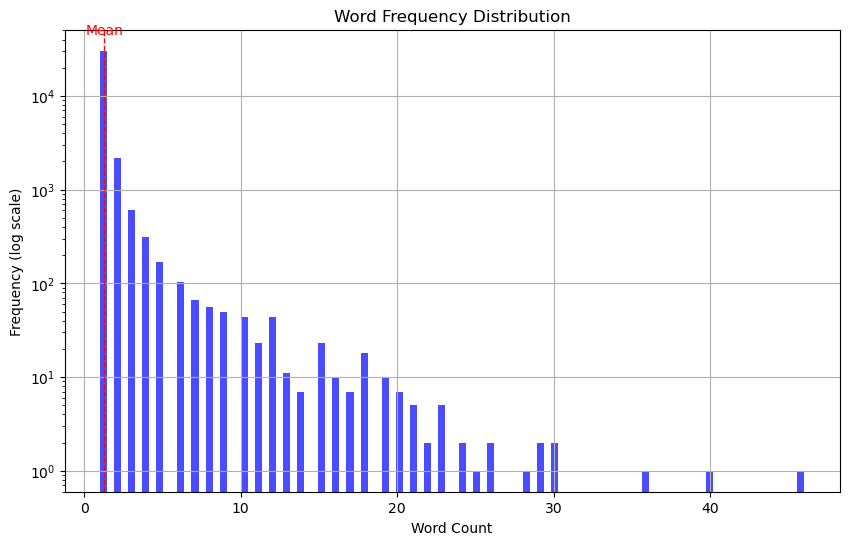

Mean:  1.29
Median:  1.0


In [23]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,2))
word_counts = vectorizer.fit_transform(train_set2['text'])
word_frequencies = np.array(word_counts.sum(axis=0)).flatten()

median = np.percentile(word_frequencies, 50)
mean = np.round(word_frequencies.sum()/len(word_frequencies), 2)

word_freq_df = pd.DataFrame({'Word': vectorizer.get_feature_names_out(),
                             'Frequency': word_frequencies}).sort_values(by='Frequency', ascending=False)


plt.figure(figsize=(10, 6))
plt.hist(word_frequencies, bins=100, log=True, alpha=0.7, color='blue')
plt.title("Word Frequency Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency (log scale)")
plt.grid()

plt.axvline(mean, color='red', linestyle='dashed', linewidth=1)
plt.text(mean, plt.ylim()[1]*0.9, 'Mean', color='red', ha='center')

plt.show()
print("Mean: ", mean)
print("Median: ", median)

In [24]:
import time

for i in [1, 2]:
    start_time = time.time()
    
    M = i 
    vectorizer = CountVectorizer(ngram_range=(2,2), min_df=M)

    X_train_set = vectorizer.fit_transform(train_set2['text'])
    y_train_set = train_set2['target']

    dev_set2 = preprocessing(dev_set)
    X_dev_set = vectorizer.transform(dev_set2['text'])
    y_dev_set = dev_set2['target']

    num_features = len(vectorizer.get_feature_names_out())
    
    print(f'M = {i}')
    print(f'Total number of features: {num_features}')

    end_time = time.time()

    print("Execution time:", end_time - start_time, "seconds")

M = 1
Total number of features: 34120
Execution time: 1.3981082439422607 seconds
M = 2
Total number of features: 3647
Execution time: 1.3260278701782227 seconds


In [25]:
import time

M = 2 
vectorizer = CountVectorizer(ngram_range=(2,2), min_df=M)

X_train_set = vectorizer.fit_transform(train_set2['text'])
y_train_set = train_set2['target']

dev_set2 = preprocessing(dev_set)
X_dev_set = vectorizer.transform(dev_set2['text'])
y_dev_set = dev_set2['target']

num_features = len(vectorizer.get_feature_names_out())

print(f'Total number of features: {num_features}')
print(f'Training set shape: {X_train_set.shape}')
print(f'Development set shape: {X_dev_set.shape}')
print(f'First 10 words in the vocabulary: \n {word_freq_df.Word[:10].to_list()}')

Total number of features: 3647
Training set shape: (5329, 3647)
Development set shape: (2284, 3647)
First 10 words in the vocabulary: 
 ['body bag', 'suicide bomber', 'look like', 'northern california', 'youtube video', 'gon na', 'like youtube', 'california wildfire', 'oil spill', 'mass murder']


## Implementing Logistic Regression (N-gram Model)

In [26]:
f1_scores_ngram = {}

In [27]:
for i in [None, 'l1', 'l2']:
    log_reg = LogisticRegression(penalty=i, solver='saga', max_iter=2000)  
    log_reg.fit(X_train_set, y_train_set)

    y_train_pred = log_reg.predict(X_train_set)
    y_dev_pred = log_reg.predict(X_dev_set)

    # Calculate F1 scores
    f1_train = f1_score(y_train_set, y_train_pred)
    f1_dev = f1_score(y_dev_set, y_dev_pred)

    f1_scores_ngram[f'Logistic Regression - {i} Regularization '] = [f1_train, f1_dev]

/Users/atmikapai/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Implementing Bernoulli Naive Bayes (N-gram Model)

In [28]:
X_train_binary = X_train_set.toarray()
y_train_binary = y_train_set.tolist()

X_dev_binary = X_dev_set.toarray()
y_dev_binary = y_dev_set.tolist()

nb_classifier = BernoulliNaiveBayes(alpha=1.0)
nb_classifier.fit(X_train_binary, y_train_binary)

y_train_pred = nb_classifier.predict(X_train_binary)
y_dev_pred = nb_classifier.predict(X_dev_binary)

f1_train = f1_score(y_train_binary, y_train_pred)
f1_dev = f1_score(y_dev_binary, y_dev_pred)

f1_scores_ngram['Bernoulli Naive Bayes'] = [f1_train, f1_dev]

## Model Comparison

<font color='darkblue'> There is a stark difference in F1 scores of train and development set. This suggests that the N-gram model is overfitting on training set and failing to generalize on unseen data.

In [29]:
f1_scores_df = pd.DataFrame(f1_scores_ngram)
f1_scores_df.index = ['Train', 'Development']
f1_scores_df.index.name = 'F1 Scores - N-Gram Model'
f1_scores_df.T

F1 Scores - N-Gram Model,Train,Development
Logistic Regression - None Regularization,0.789435,0.577632
Logistic Regression - l1 Regularization,0.628157,0.514749
Logistic Regression - l2 Regularization,0.732493,0.569231
Bernoulli Naive Bayes,0.622144,0.495792


# Bag of Words vs N-Gram Model

In [30]:
f1_scores_df = pd.DataFrame(f1_scores)
f1_scores_df.index = ['Train', 'Development']
f1_scores_df.index.name = 'F1 Scores - Bag of Words Model'
f1_scores_df.T

F1 Scores - Bag of Words Model,Train,Development
Logistic Regression - No Regularization,0.950077,0.679651
Logistic Regression - L1 Regularization,0.833912,0.739514
Logistic Regression - L2 Regularization,0.859116,0.738729
Bernoulli Naive Bayes,0.792587,0.747440


<font color='darkblue'> The Bag of Words model outperform N-gram model across train and development sets, logistic regression, and Bernoulli Naive Bayes models. 
    
<font color='darkblue'> The highest F1-score on the development set was 0.577 for the N-gram model and 0.747 for the Bag of Words model, indicating that the latter is better at predicting whether a tweet pertains to a real disaster or not. 
    
<font color='darkblue'> The N-gram model is overfitting, as evidenced by the stark differences in F1 scores between training and development set. The Bag of Words model effectively captures the overall frequency of relevant words without the complications introduced by n-gram combinations. This implies that for the task of predicting whether a tweet pertains to a real disaster or not, capturing individual word frequencies (as in the Bag of Words model) is more effective than focusing on word combinations (as in the n-gram model). Moreover, since tweets are short, n-grams can lead to sparsity issues, as many word combinations might not appear frequently enough to be informative. With shorter texts like Tweets, the Bag of Words model is better suited.

# Determining performance on Kaggle test set

<font color='darkblue'> I will re-build my feature vectors and re-train on my preferred classifier (either bag of word or n-gramusing either logistic regression or Bernoulli naive bayes) using the entire Kaggle training data. Then, I will test it on the Kaggle test data. 

In [31]:
train_set = preprocessing(train)
test_set = preprocessing(test)

M = 5  #based on mean and common NLP practices
vectorizer = CountVectorizer(binary=True, min_df=M)

X_train = vectorizer.fit_transform(train_set['text']).toarray()
y_train = train_set['target'].tolist()

X_test = vectorizer.transform(test_set['text']).toarray()

In [32]:
nb_classifier = BernoulliNaiveBayes(alpha=1.0)
nb_classifier.fit(X_train, y_train)

y_train_pred = nb_classifier.predict(X_train)
y_test_pred = nb_classifier.predict(X_test)

f1_train = f1_score(y_train, y_train_pred)

print(f"F1 Score on Kaggle Training Set using Bag of Words Model and Bernoulli Naive Bayes Classifier: {f1_train}")

F1 Score on Kaggle Training Set using Bag of Words Model and Bernoulli Naive Bayes Classifier: 0.7932135057953973


<font color='darkblue'> On the Kaggle training set, I have an F1 score of 0.793 using the Bag of Words model and Bernoulli Naive Bayes classifier. This matches my expectation, because it aligns with the F1 score I saw when I only used 70% of my training set. 
    
<font color='darkblue'> On the Kaggle test set, I have an F1 score of 0.794 as seen in the image below. I expected the accuracy to be lower on my test set due to overfitting, but it perfectly aligns with the F1 score on my training set. It may be higher than expectation, because my model is good at generalizing patterns and predicting on unseen data. The test set may also be very similar to the training set, resulting in closely aligned scores.  The organizers may ensure this distribution similarity for fair benchmarking.

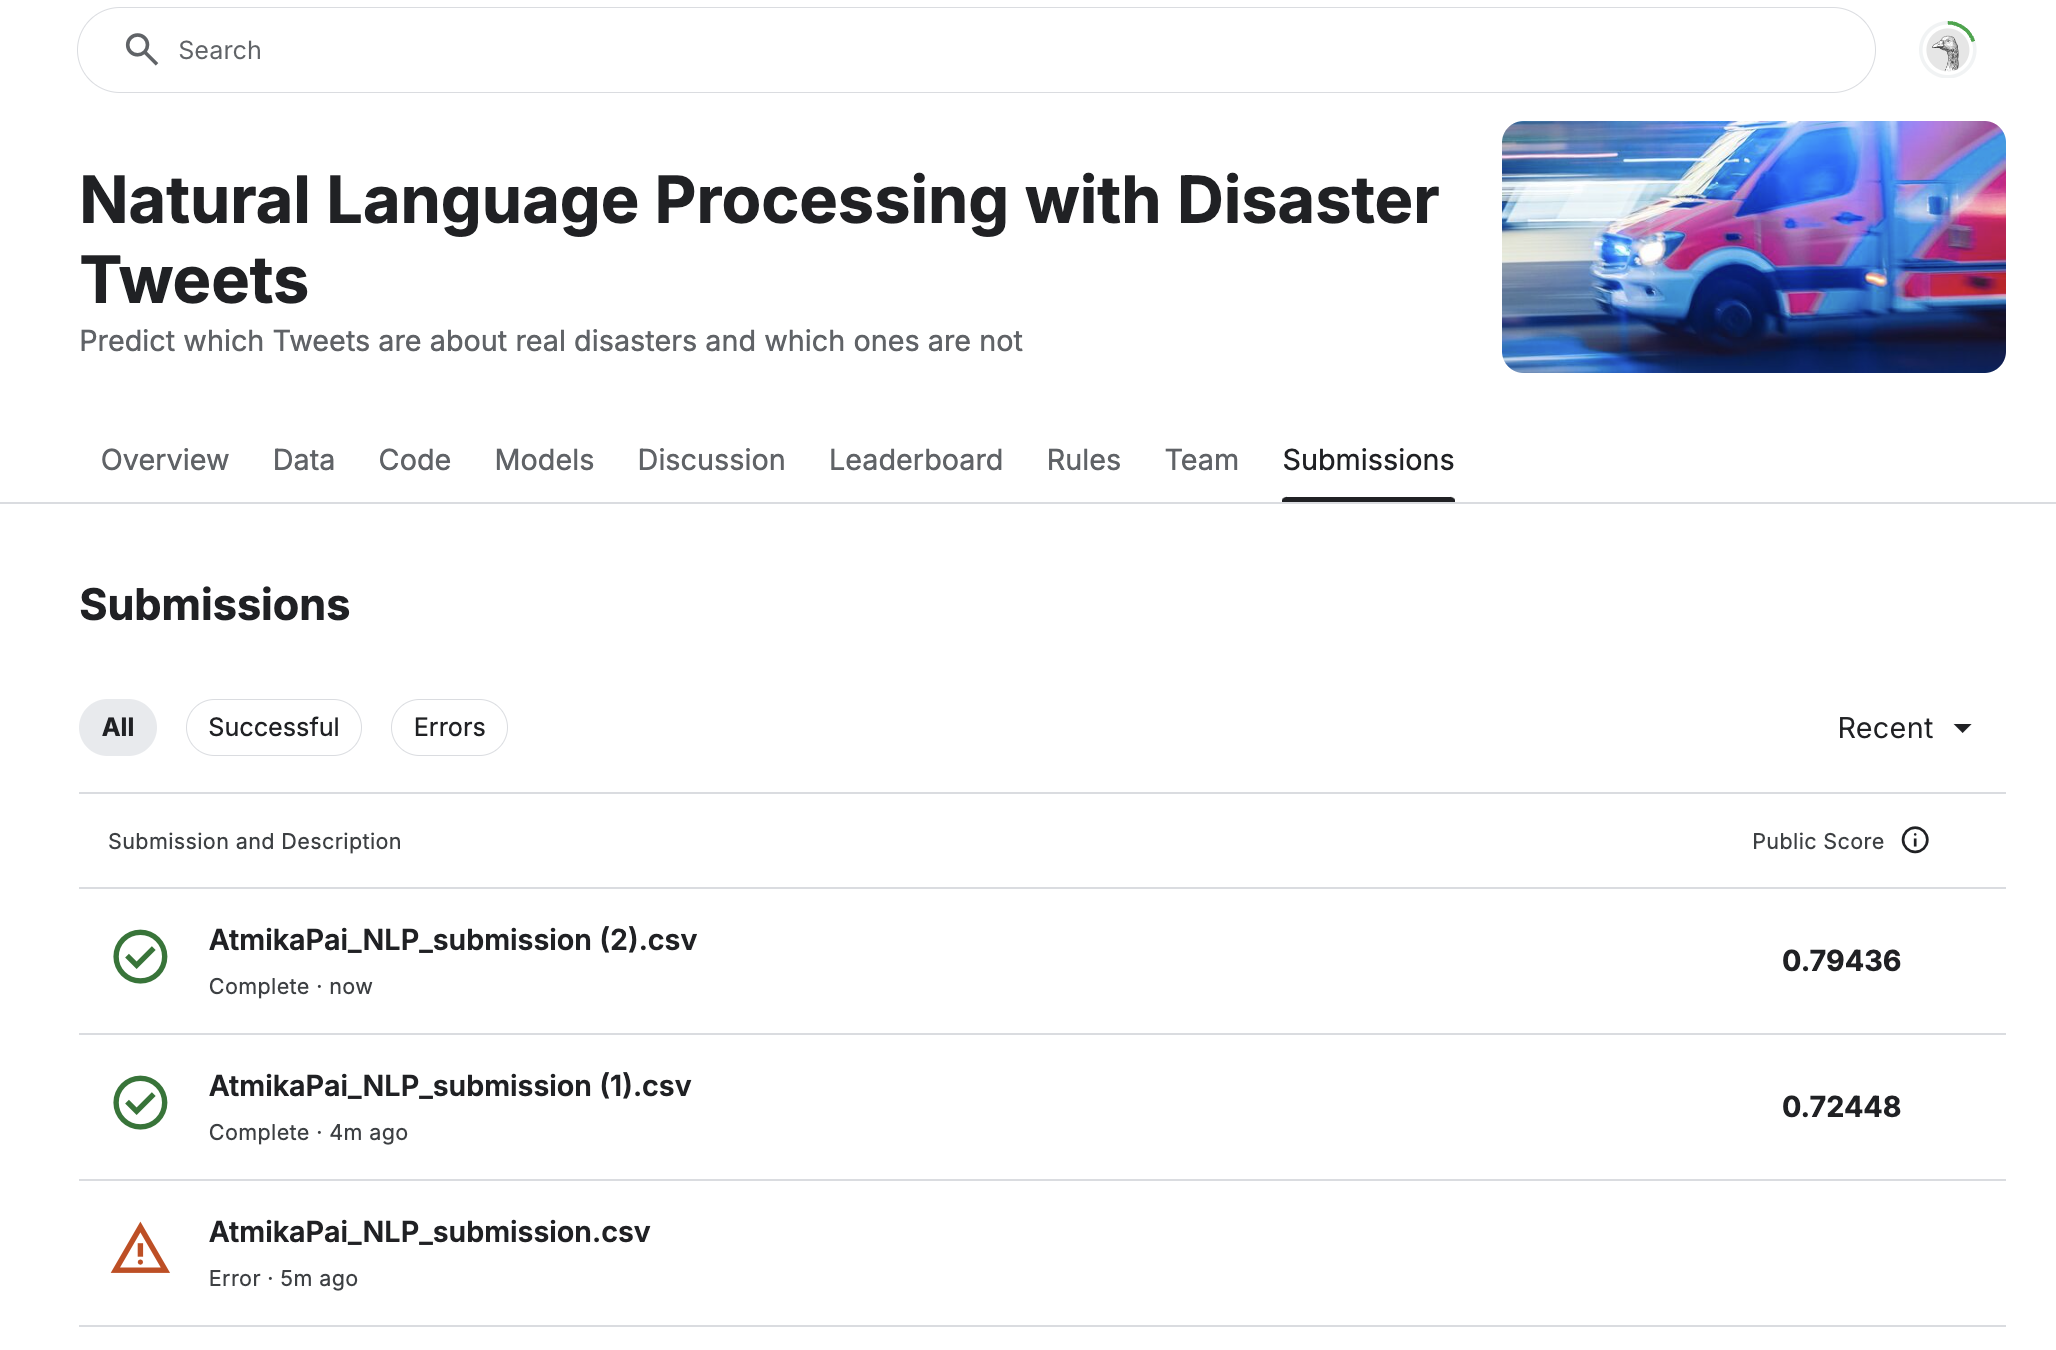

In [33]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = y_test_pred
submission.to_csv('AtmikaPai_NLP_submission.csv', index=False)

from IPython.display import Image
Image(filename='Kaggle_submission.png') 